In [2]:

import numpy as np
import matplotlib.pyplot as plt
import json
import scipy
from pathlib import Path



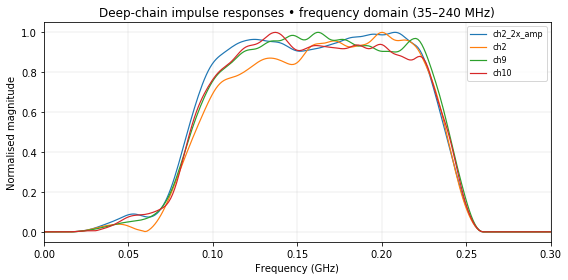

In [11]:

# --------- CONFIG --------------------------------------------------------- #
json_path   = Path("/home/shamshassiki/Shams_Analyzing_scripts/Trigger_simulation_and_tests/jsons/impulse_response_Freauency_35_240.json")  # adjust path
thin_width  = 1.2
title       = "Deep-chain impulse responses • frequency domain (35–240 MHz)"
# -------------------------------------------------------------------------- #

# --------- LOAD ----------------------------------------------------------- #
with json_path.open() as fh:
    data = json.load(fh)

freq_GHz = np.asarray(data["freq_GHz"])   # common x-axis
chan_keys = [k for k in data if k != "freq_GHz"]

# --------- PLOT ----------------------------------------------------------- #
fig, ax = plt.subplots(figsize=(8, 4))

for k in chan_keys:
    mag = np.asarray(data[k])
    ax.plot(freq_GHz, mag, lw=thin_width, label=k)

ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Normalised magnitude")
ax.set_title(title)
ax.set_xlim(freq_GHz.min(), freq_GHz.max())
ax.grid(True, lw=0.3, alpha=0.7)
ax.legend(loc="upper right", fontsize=8)
plt.xlim(0,0.3)
plt.tight_layout()
plt.show()

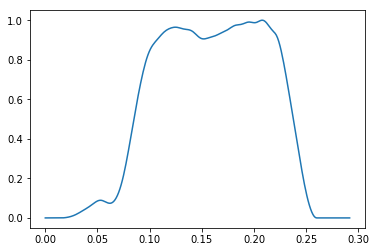

In [12]:
sig_samples=250
Frequency_domain  =  np.asarray(data["ch2_2x_amp"])
freq_respons  =  freq_GHz[:sig_samples]
Frequency_domain  =  Frequency_domain[:sig_samples]


plt.plot(freq_respons, Frequency_domain)
plt.show()

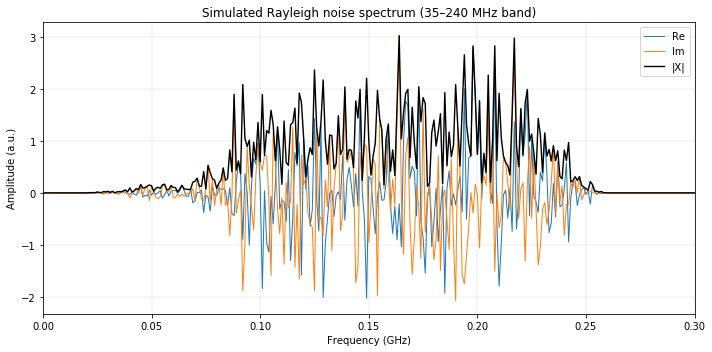

sigma length  945


In [13]:

# ─── parameters for the noise window ─────────────────────────────────────── #
noise_time_window_ns = 1000.0            # desired time span [ns]
TIME_STEP_ns         = 1 / (0.472*4)    # ≈ 0.53 ns sample spacing
N                    = int(round(noise_time_window_ns / TIME_STEP_ns))  # samples
dt_s                 = TIME_STEP_ns * 1e-9                               # Δt [s]

# ─── load system frequency response (magnitude) ─────────────────────────── #
resp_path = Path("/home/shamshassiki/Shams_Analyzing_scripts/Trigger_simulation_and_tests/jsons/impulse_response_Freauency_35_240.json")  # adjust path

resp_freq = freq_respons           # GHz
resp_mag  = Frequency_domain               # choose one channel or avg

# ─── construct new frequency grid for the noise window (one-sided) ───────── #
freq_Hz = np.fft.rfftfreq(N, d=dt_s)               # Hz
freq_GHz = freq_Hz / 1e9

# ─── interpolate system magnitude onto new grid → Rayleigh scale parameter ─ #
sigma = np.interp(freq_GHz, resp_freq, resp_mag, left=0.0, right=0.0)

# ─── draw Rayleigh amplitudes & random phases ────────────────────────────── #
rng    = np.random.default_rng()
amp    = rng.rayleigh(scale=sigma)                 # Rayleigh amplitudes
phase  = rng.uniform(0, 2*np.pi, size=amp.size)    # random phase
noise_spec = amp * np.exp(1j*phase)                # complex spectrum

# ─── plot real, imag, magnitude (positive-freq bins) ─────────────────────── #
plt.figure(figsize=(10,5))
plt.plot(freq_GHz, noise_spec.real,  lw=1, label="Re")
plt.plot(freq_GHz, noise_spec.imag,  lw=1, label="Im")
plt.plot(freq_GHz, np.abs(noise_spec), lw=1.4, label="|X|", color="k")
plt.xlim(freq_GHz.min(), freq_GHz.max())
plt.xlabel("Frequency (GHz)")
plt.xlim(0,0.3)
plt.ylabel("Amplitude (a.u.)")
plt.title("Simulated Rayleigh noise spectrum (35–240 MHz band)")
plt.legend(); plt.grid(True, lw=0.3, alpha=0.7)
plt.tight_layout(); plt.show()
print('sigma length ', len(sigma))


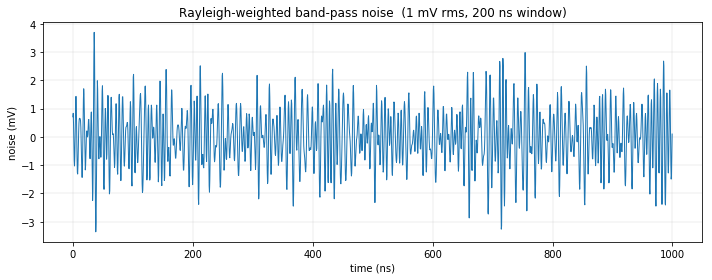

In [14]:
# ---------------------------------------------------------------------------
# inverse FFT  →  time-domain noise  (length N, Δt = TIME_STEP_ns)
# ---------------------------------------------------------------------------
noise_td = np.fft.irfft(noise_spec, n=N)        # real-valued waveform

# ---------------------------------------------------------------------------
# scale so the waveform has ≈ 1 mV rms
# ---------------------------------------------------------------------------
target_rms_mV = 1.0                             # desired root-mean-square
rms_in        = np.sqrt(np.mean(noise_td**2))   # current rms (a.u.)
noise_td_mV   = noise_td / rms_in * target_rms_mV

# create matching time axis (ns)
time_ns = np.arange(N) * TIME_STEP_ns           # TIME_STEP_ns ≈ 0.53 ns

# quick check / plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(time_ns, noise_td_mV, lw=1)
plt.xlabel("time (ns)"); plt.ylabel("noise (mV)")
plt.title("Rayleigh-weighted band-pass noise  (1 mV rms, 200 ns window)")
plt.grid(True, lw=0.3, alpha=0.7)
plt.tight_layout(); plt.show()


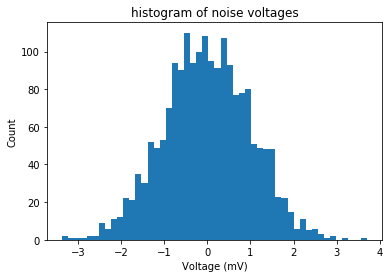

In [15]:
len(noise_td_mV)
plt.hist(noise_td_mV, bins=50)
plt.title('histogram of noise voltages')
plt.xlabel('Voltage (mV)')
plt.ylabel('Count')
plt.show()